In [1]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.10.0
2.10.0


In [2]:
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.utils import pad_sequences
from keras.layers import Masking
from tensorflow.python.client import device_lib
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pickle import dump
from pickle import load
import pandas as pd

In [3]:
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4521275428474618650
xla_global_id: -1
]


In [4]:
df = pd.read_csv("./dfcsv4.csv")
df_test = pd.read_csv("./dfcsv_anomaly.csv")

In [5]:

arr = df.to_numpy()
arr_test = df_test.to_numpy()
print(df)
print(arr[3])

      num         time        gX        gY        gZ     aX     aY     aZ  \
0     0.0          0.0  0.000314  0.000593 -0.002164 -0.010  0.014  0.081   
1     0.0      98565.0 -0.002094  0.009128  0.002094 -0.012  0.003 -0.091   
2     0.0     196171.0  0.000838  0.005934 -0.001100 -0.005 -0.002 -0.035   
3     0.0     293674.0 -0.002880  0.000070 -0.000035 -0.009 -0.011  0.019   
4     0.0     391150.0 -0.006877  0.003526 -0.000297 -0.011  0.007 -0.009   
...   ...          ...       ...       ...       ...    ...    ...    ...   
7483  0.0  748411479.0  0.001379 -0.002862  0.002897 -0.004 -0.001 -0.102   
7484  0.0  748557749.0 -0.002618 -0.000471  0.000768  0.007 -0.007 -0.106   
7485  0.0  748655230.0  0.002182 -0.000209  0.003438  0.020 -0.005 -0.096   
7486  0.0  748752752.0  0.001641 -0.002601 -0.001902  0.017 -0.009 -0.084   
7487  0.0  748898997.0 -0.001012 -0.006597  0.001571  0.006  0.005 -0.093   

         pitch      roll  
0     0.169884 -0.121058  
1     0.032672 -0.131

C:\Users\user\AppData\Local\Temp\ipykernel_17084\3453654976.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


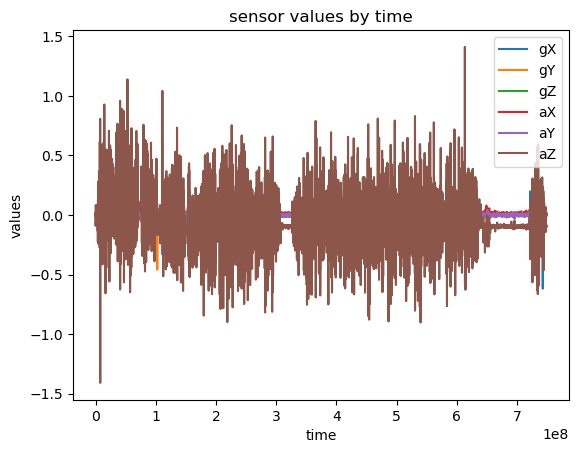

In [6]:
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
ax.plot(df['time'],df['gX'],label='gX')
ax.plot(df['time'],df['gY'],label='gY')
ax.plot(df['time'],df['gZ'],label='gZ')
ax.plot(df['time'],df['aX'],label='aX')
ax.plot(df['time'],df['aY'],label='aY')
ax.plot(df['time'],df['aZ'],label='aZ')
ax.set_xlabel('time')
ax.set_ylabel('values')
ax.set_title('sensor values by time')
ax.legend()
fig2.show()

In [7]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(arr[:,2:])
test_scaled = scaler.transform(arr_test[:,2:])
dump(scaler,open('./minmax_scaler.pkl','wb'))

In [8]:
# 시퀀스 데이터 생성 함수
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequences = create_sequences(train_scaled, 1)
sequences_test = create_sequences(test_scaled,1)

In [9]:
def create_lstm_autoencoder(sequence_length,num_features):
    inputs = Input(shape=(sequence_length,num_features))

    encoded = LSTM(32,activation='relu',return_sequences=True)(inputs)
    encoded = LSTM(4,activation='relu',return_sequences=False)(encoded)
    encoded = RepeatVector(sequence_length)(encoded)

    decoded = LSTM(4,activation='relu',return_sequences=True)(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(num_features))(decoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    return autoencoder

autoencoder = create_lstm_autoencoder(sequences.shape[1],sequences.shape[2])
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)



In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 32)             5248      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 592       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 32)             4736      
                                                             

In [11]:
history=autoencoder.fit(sequences, sequences, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping]).history

Epoch 1/100
211/211 [==============================] - 8s 10ms/step - loss: 0.1623 - accuracy: 0.1763 - val_loss: 0.0028 - val_accuracy: 0.9105
Epoch 2/100
211/211 [==============================] - 1s 5ms/step - loss: 0.0063 - accuracy: 0.7729 - val_loss: 0.0025 - val_accuracy: 0.9105
Epoch 3/100
211/211 [==============================] - 1s 6ms/step - loss: 0.0057 - accuracy: 0.7729 - val_loss: 0.0023 - val_accuracy: 0.9105
Epoch 4/100
211/211 [==============================] - 1s 5ms/step - loss: 0.0054 - accuracy: 0.7729 - val_loss: 0.0022 - val_accuracy: 0.9105
Epoch 5/100
211/211 [==============================] - 1s 5ms/step - loss: 0.0054 - accuracy: 0.7729 - val_loss: 0.0022 - val_accuracy: 0.9105
Epoch 6/100
211/211 [==============================] - 1s 5ms/step - loss: 0.0053 - accuracy: 0.7729 - val_loss: 0.0022 - val_accuracy: 0.9105
Epoch 7/100
211/211 [==============================] - 1s 6ms/step - loss: 0.0052 - accuracy: 0.7729 - val_loss: 0.0022 - val_accuracy: 0.910

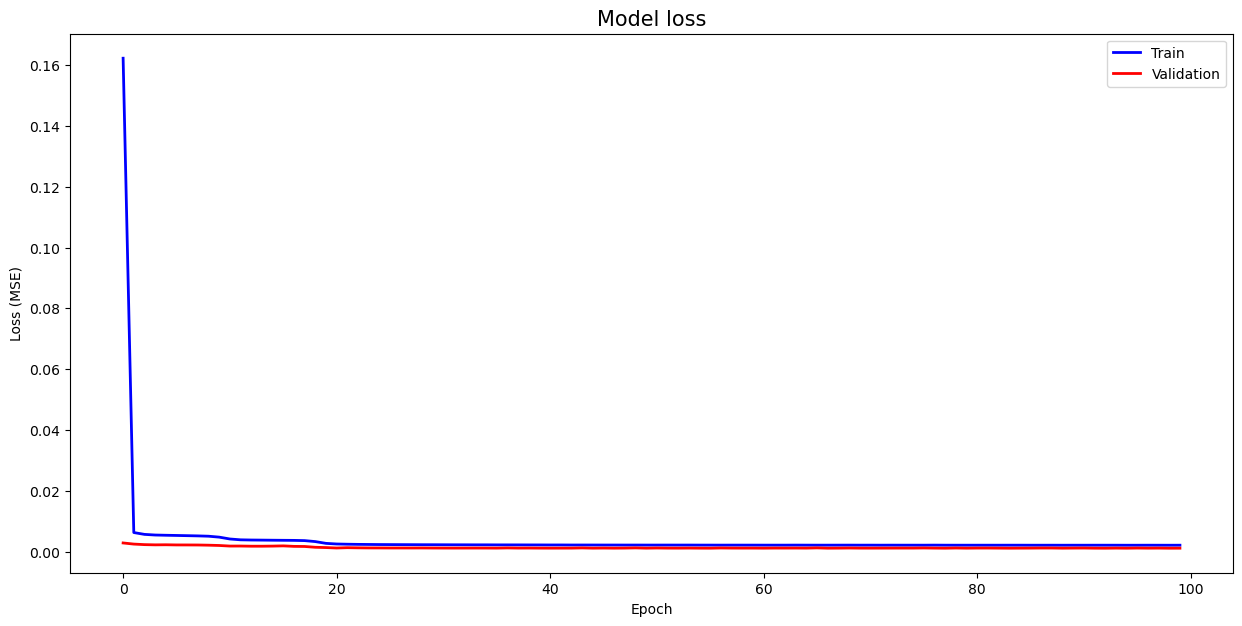

In [12]:
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(history['loss'],'b',label='Train',linewidth=2)
ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model loss',fontsize=15)
ax.set_ylabel('Loss (MSE)')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

In [13]:
pred_train = autoencoder.predict(sequences)
print(pred_train.shape)


234/234 [==============================] - 1s 2ms/step
(7487, 1, 8)


In [14]:
def calculate_error(original,reconstructed):
  return np.mean(np.abs(original-reconstructed),axis=(1))

reconstructed_error = calculate_error(sequences,pred_train)

print(reconstructed_error[0])
print(reconstructed_error[1])

[0.00482884 0.05482352 0.04941115 0.00813397 0.01801414 0.03827385
 0.01246869 0.01220526]
[0.00558774 0.0418068  0.00469345 0.00770589 0.00196222 0.05420624
 0.01566948 0.01729416]


In [15]:
reconstructed_error.shape

(7487, 8)

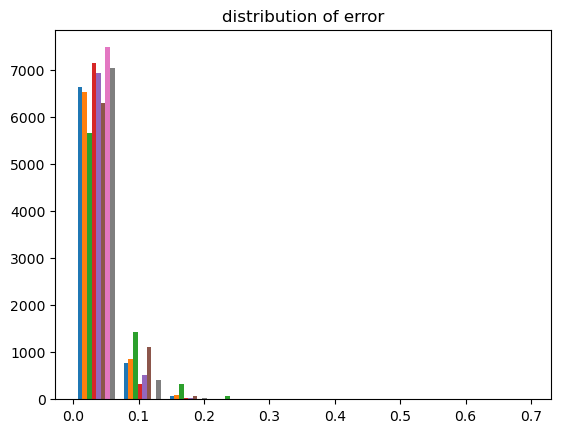

In [16]:
plt.hist(reconstructed_error)
plt.title('distribution of error')
plt.show()

In [17]:
pred_test = autoencoder.predict(sequences_test)
#print(pred_test)
pred_test.shape

26/26 [==============================] - 0s 4ms/step


(812, 1, 8)

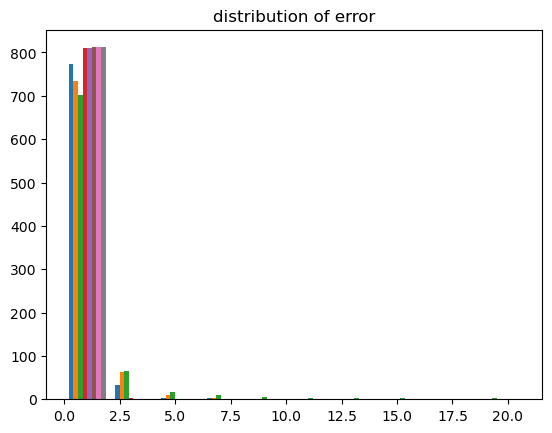

In [18]:
reconstructed_error_test = calculate_error(sequences_test,pred_test)
plt.hist(reconstructed_error_test)
plt.title('distribution of error')
plt.show()

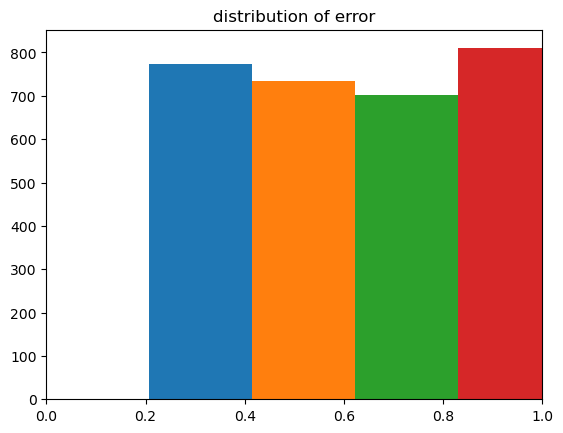

In [19]:
reconstructed_error_test = calculate_error(sequences_test,pred_test)
plt.hist(reconstructed_error_test)
plt.title('distribution of error')
plt.xlim([0, 1])
plt.show()

In [20]:
from tensorflow import keras
autoencoder.save('model.h5')

In [21]:
scaler = load(open('./minmax_scaler.pkl','rb'))

min_ = scaler.min_
scale_ = scaler.scale_

print("min_: ", min_)
print("scale_: ", scale_)

min_:  [0.66223519 0.76072856 0.65273372 0.61111111 0.59532374 0.49964539
 0.50183961 0.51558958]
scale_:  [ 1.07132962  1.65911217 10.69150579  2.77777778  1.79856115  0.35460993
  0.32241303  0.33680666]


In [22]:
run_model = tf.function(lambda x: autoencoder(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 1
INPUT_SIZE = 8
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], autoencoder.inputs[0].dtype))

# model directory.
MODEL_DIR = "model"
autoencoder.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
#https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/examples/experimental_new_converter/Keras_LSTM_fusion_Codelab.ipynb?hl=pt#scrollTo=tB1NZBUHDogR

INFO:tensorflow:Assets written to: model\assets


In [23]:
open("model.tflite","wb").write(tflite_model)

53456

In [28]:
!xxd -i model.tflite > model.cc